In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from collections import OrderedDict 
#from tqdm.autonotebook import tqdm

In [2]:
#agent

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #wealth is the total wealth, P-most probable money, m is the wealth
        #at each time step
        self.m = self.model.T
        
        

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position   = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        lamda = self.model.lamda
        epsilon = random.random()
        if len(cellmates) > 1 :
            other = self.random.choice(cellmates)
            if(other.unique_id != self.unique_id):
                #print(self)
                #print(other)
                #print(self.m, other.m, self.m + other.m)
                xi = self.m
                xj = other.m
                xi_new= round(lamda*xi + epsilon*(1-lamda)*(xi+xj),3)
                xj_new = round(lamda*xj + (1-epsilon)*(1-lamda)*(xi+xj),3)
                other.m = xj_new
                self.m = xi_new
                #print(self.m, other.m, self.m + other.m)
                #print(xi_new, xj_new, xi_new+xj_new)
                #print("break")

    def step(self):
        self.move()
        if self.m > 0:
            self.give_money()
       

In [3]:
#model

#saving propensity = lamda
class BoltzmannWealthModel(Model):

    def __init__(self,T,N,lamda, width=10, height=10):
        self.num_agents = N
        self.T = T
        self.grid = MultiGrid(height, width, True)
        self.lamda = lamda
        self.count = 0
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(agent_reporters={ 'mi':'m'})
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.count+=1
            #print("step:{}".format(i))
            self.step()


In [6]:
N = 500 #number of agents
T = 100 #average money per agent
M = N*T #total_money
lamda = 0.4 #saving propensity
steps = 500
model = BoltzmannWealthModel(T,N, lamda)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
agent_df['Step'] = agent_df.index


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Text(0.5, 0, '$\\frac{m}{T}$')

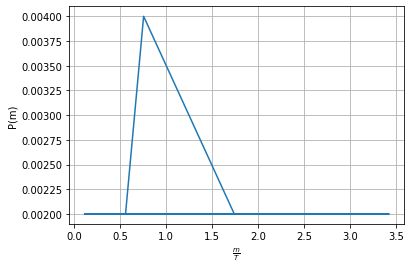

In [27]:
P = []
mT = []
x = ((agent_df[agent_df['Step'] == 50].mi).reset_index(drop=True)).to_numpy()

#rounding off pf all mi values (different plots)
#for i in range(len(x)):
    #x[i] = round(x[i],2)
    
#counting the occurrence of each value of x to find probability
result = Counter(x)
#print(result)
#result = OrderedDict(sorted(result.items())) 

#finding probability
for i in result:
    #print(i,result[i]/500 )
    P.append(result[i]/500) #number of occurrence of a certain m value / total number of agents
    mT.append(i/T)
plt.plot(mT,P)
plt.grid()
plt.ylabel("P(m)")
plt.xlabel("$\\frac{m}{T}$")